# Extracciones
En el siguiente cuaderno se tratan las extracciones de datos complementarias a los datasets originales. Se realizan un total de dos extracciones:

1. Códigos CIIU.
2. Ruralidad de los municipios de Colombia.

Los códigos CIIU almacenan información acerca de las actividades que realiza la empresa de forma jerárquica. Esta información puede ser realmente útil para poder agrupar las empresas según varios criterios.

Por la otra parte, la ruralidad es una categoría de las ciudades que describe su grado de urbanización. Se decide extraer la ruralidad de cada municipio colombiano, ya que otros estudios anteriores, como Blažková and Dvouletý (2020), utilizaron la ruralidad como descriptor de las empresas zombis.

## Extracción de códigos CIIU
La siguiente sección trata de una extracción de los códigos ciiu de actividades en Colombia a partir de los datos del DANE. La extracción se basa en la publicación de la siguiente [página del instituto](https://www.dane.gov.co/index.php/sistema-estadistico-nacional-sen/normas-y-estandares/nomenclaturas-y-clasificaciones/clasificaciones/clasificacion-industrial-internacional-uniforme-de-todas-las-actividades-economicas-ciiu). La copia utilizada como fuente de datos se puede consultar en el fichero: **data/EstructuraDetalladaCIIU.xls.**

El código CIIU está compuesto por un conjunto de dígitos que distinguen de forma jerárquica la actividad de operación de las empresas.

El dataset resultante está compuesto por las siguientes columnas:

* Código CIIU original
* Sección
* División
* Grupo
* Clase

Por ejemplo:

El código CIIU **A0111** denota:

* Sección A: AGRICULTURA, GANADERÍA, CAZA, SILVICULTURA Y PESCA
* División 01: Agricultura, ganadería, caza y actividades de servicios conexas
* Grupo 011: Cultivos agrícolas transitorios
* Clase 0111: Cultivo de cereales (excepto arroz), legumbres y semillas oleaginosas

El siguiente algoritmo se encarga de obtener el dataset resultante a partir de la fuente de datos publicada en el DANE.

In [7]:
# Importes necesarios para el cuaderno
import xlrd
import re
import pandas as pd
import unidecode
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

In [2]:
# Especificar el máximo de filas del excel
MAX_ROWS = 713
# Leer los datos
book = xlrd.open_workbook("data/EstructuraDetalladaCIIU.xls")
sh = book.sheet_by_index(0)

# Función para extraer la información jerárquica del excel de códigos CIIU
def extract_level(parent, column, regex):
    items = []
    for row in range(parent['start'], parent['end']+1):
        cell = sh.cell(row, column)
        matches = re.match(regex, str(cell.value))
        if (matches):
            item = matches.group(1)
            if (len(items) > 0):
                items[-1]['end'] = row-1
            items = items + [{'code':item,'desc':sh.cell(row,3).value,'start':row,'end':-1}]

    items[-1]['end'] = parent['end']                              
    return items
 
def build_ciiu(seccion, seccionDesc, division, divisionDesc, grupo, grupoDesc, clase, claseDesc):
    return {'Ciiu':seccion+clase, 'Seccion': seccion, 'SeccionDesc':seccionDesc, 'Division': division, 'DivisionDesc': divisionDesc, \
            'Grupo': grupo, 'GrupoDesc': grupoDesc, 'Clase': clase, 'ClaseDesc': claseDesc}

# Proceso de extracción jerárquica de los códigos ciiu
parent = {'start':3,'end':MAX_ROWS}
result = []
secciones = extract_level(parent, 0, r'^SECCIÓN\s*(\w+)\s*$')
for seccion in secciones:
    divisiones = extract_level(seccion, 0, r'^(\d+)(?:\.0)?$')
    seccion['divisiones'] = divisiones
    for division in divisiones:
        groups = extract_level(division, 1, r'^(\d+)(?:\.0)?$')
        division['grupos'] = groups
        for group in groups:
            clases = extract_level(group, 2, r'^(\d+)(?:\.0)?$')
            group['clases'] = clases
            for clase in clases:
                result = result + [build_ciiu(seccion['code'], seccion['desc'], division['code'], division['desc'], group['code'], group['desc'], clase['code'], clase['desc'])]
            
df = pd.DataFrame(result)
df.to_csv('data/ExtraccionCIIU.csv', sep=';', encoding='utf-8', index=False)
df.head()

,Ciiu,Seccion,SeccionDesc,Division,DivisionDesc,Grupo,GrupoDesc,Clase,ClaseDesc
0,A0111,A,"AGRICULTURA, GANADERÍA, CAZA, SILVICULTURA Y P...",01,"Agricultura, ganadería, caza y actividades de ...",011,Cultivos agrícolas transitorios,0111,"Cultivo de cereales (excepto arroz), legumbres..."
1,A0112,A,"AGRICULTURA, GANADERÍA, CAZA, SILVICULTURA Y P...",01,"Agricultura, ganadería, caza y actividades de ...",011,Cultivos agrícolas transitorios,0112,Cultivo de arroz
2,A0113,A,"AGRICULTURA, GANADERÍA, CAZA, SILVICULTURA Y P...",01,"Agricultura, ganadería, caza y actividades de ...",011,Cultivos agrícolas transitorios,0113,"Cultivo de hortalizas, raíces y tubérculos"
3,A0114,A,"AGRICULTURA, GANADERÍA, CAZA, SILVICULTURA Y P...",01,"Agricultura, ganadería, caza y actividades de ...",011,Cultivos agrícolas transitorios,0114,Cultivo de tabaco
4,A0115,A,"AGRICULTURA, GANADERÍA, CAZA, SILVICULTURA Y P...",01,"Agricultura, ganadería, caza y actividades de ...",011,Cultivos agrícolas transitorios,0115,Cultivo de plantas textiles


## Extracción de la categoría rural
En segundo lugar, se puede extraer la categoría rural de cada municipio Colombiano. Existen varias definiciones acerca de cómo separar los territorios según urbanos o rurales. En la mayoría de casos se utiliza la población total del municipio y se establece un punto de corte.

Sin embargo, en Colombia existe [un estudio](https://colaboracion.dnp.gov.co/CDT/Estudios%20Econmicos/2015ago6%20Documento%20de%20Ruralidad%20-%20DDRS-MTC.pdf) realizado por la Dirección de Desarrollo Rural Sostenible (DDRS) con la finalidad de crear categorías rurales específicas para el país.

En el estudio, se utiliza el criterio de la población de la cabecera del municipio (perímetro urbano), la densidad de población, y la proporción de población en la zona resto (población fuera de la cabecera) para crear un total de 4 categorías urbanas:

* Urbana.
* Intermedia.
* Rural.
* Rural dispersa.

La lógica de clasificación se resume en la siguiente tabla:

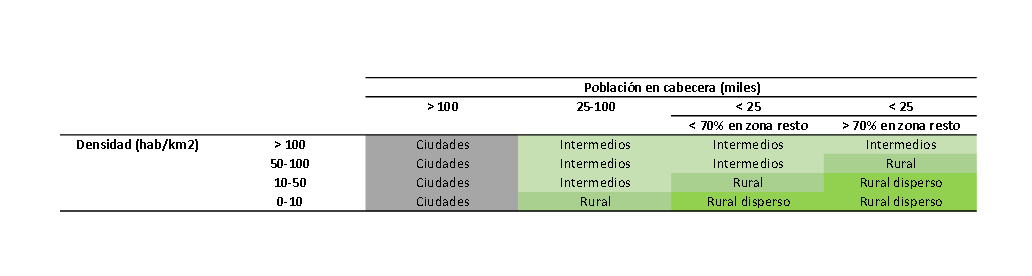

In [3]:
# Mostrar una imagen
Image(filename='assets/CategoriasRurales.PNG')

Aunque el estudio incluye un listado de municipios categorizados, se tratan de datos del 2014. Y además, no es trivial extraerlos de un fichero pdf. Por consiguiente, se realizará el cálculo de la ruralidad de nuevo utilizando unos datos poblacionales más actualizados.

* La población de cada ciudad (así como en la cabecera y en la zona resto), se extrae del DANE en el siguiente [enlace](https://www.dane.gov.co/index.php/estadisticas-por-tema/demografia-y-poblacion/censo-nacional-de-poblacion-y-vivenda-2018)
* La densidad poblacional de cada municipio. Extraído del Centro de Recursos para el análisis de Conflictos (CERAC) [enlace](https://www.cerac.org.co/es/publicaciones/libros/viejasguerras/anexoestadistico.html)

Como apunte final, es necesario tener en cuenta que algunos municipios tienen nombres repetidos, por lo que es indispensable utilizar el nombre del departamento y del municipio conjuntamente como identificadores únicos de un municipio.

Existe una cantidad considerable de datos erróneos en los orígenes de datos encontrados (nombres de municipios y departamentos erróneos, algunas superficies de municipios sin informar, nombres distintos según el fichero... Todos estos errores también se tratan mediante el siguiente código:

In [4]:
# Abrir la fuente de datos con la población total y de cobertura de los municipios colombianos
book = xlrd.open_workbook("data/CNPV-2018-Poblacion-Ajustada-Por-Cobertura.xls")
sh = book.sheet_by_index(2)
poblaciones = []
# Leer el municipio, el total de habitantes, los habitantes de la cobertura y el departamento de cada fila de datos
for row in range(9, 1131):
    # Se guardan los nombres en minúsculas, sin carácteres especiales (como acentos) y eliminando espacios redundantes
    departamento = unidecode.unidecode(str(sh.cell(row,1).value).lower()).strip()
    municipio = unidecode.unidecode(str(sh.cell(row, 2).value).lower()).strip()
    poblacionTotal = sh.cell(row, 3).value
    poblacionCabecera = sh.cell(row, 4).value
    poblaciones = poblaciones + \
        [{'Municipio':municipio, 'Departamento':departamento, 'poblacionTotal':poblacionTotal, 'poblacionCabecera': poblacionCabecera}]

# Convertir la lista a dataset de pandas
poblaciones = pd.DataFrame(poblaciones)

# Arregla algunos municipios con el sufijo (ANM), que significa áreas no metropolitanas, cuya población en la cabecera es cero.
def arreglar_sufijo_anm(df):
    def fix_anm(val):
        if (val.endswith('(anm)')):
            return val[0:-5].strip()
        else:
            return val  
        
    df['Municipio'] = df['Municipio'].map(fix_anm)

# Arreglar el sufijo ANM
arreglar_sufijo_anm(poblaciones)
# Arreglar las diferencias entre la nomenclatura de Bogotá
poblaciones.at[poblaciones['Municipio'] == 'bogota, d.c.','Departamento'] ="bogota"
poblaciones.at[poblaciones['Municipio'] == 'bogota, d.c.','Municipio'] ="bogota"
# Arreglar el municipio de Tumaco
poblaciones.at[poblaciones['Municipio'] == 'san andres de tumaco','Municipio'] = 'tumaco'


# Lectura de los datos de la densidad poblacional por cada municipio
book = xlrd.open_workbook("data/DensidadPoblacionalv2.xls")
sh = book.sheet_by_index(0)
superficies = []
for row in range(1, 1120):
    municipio = unidecode.unidecode(str(sh.cell(row,5).value).lower()).strip()
    departamento = unidecode.unidecode(str(sh.cell(row,4).value).lower()).strip()
    superficie = sh.cell(row,10).value
    superficies = superficies + [{'Municipio':municipio,'Departamento':departamento,'Superficie':superficie}]

# Crear el dataframe a partir de la lista
superficies = pd.DataFrame(superficies) 

# Cambiar el departamento del archipielago por su nomenclatura corta
superficies.at[superficies['Departamento'] == 'archipielago de san andres, providencia y santa catalina','Departamento'] = 'archipielago de san andres'

# Municipios con el departamento erróneo que debería ser Antioquía
municipios_departamento_antioquia = ['medellin', 'abejorral', 'abriaqui', 'alejandria', 'amaga',\
       'amalfi', 'andes', 'angelopolis', 'angostura', 'anori',\
       'santafe de antioquia', 'anza', 'apartado', 'arboletes',\
       'belmira', 'bello', 'betania',\
       'copacabana', 'dabeiba', 'don matias',\
       'ebejico', 'el bagre', 'entrerrios', 'envigado', 'fredonia',\
       'frontino', 'liborina', 'maceo', 'marinilla',\
       'montebello', 'murindo', 'mutata', 'necocli', 'nechi', 'bogota']

# Municipios con el departamento erróneo que debería ser Atlántico
municipios_departamento_atlantico = ['campo de la cruz', 'palmar de varela', 'piojo',\
       'polonuevo', 'ponedera', 'repelon',\
       'sabanagrande', 'santa lucia', 'santo tomas',\
       'tubara', 'usiacuri']

# Arreglar municipios con departamento erróneo (detectados manualmente)
superficies.at[superficies['Municipio'].isin(municipios_departamento_antioquia), 'Departamento'] = 'antioquia'
superficies.at[superficies['Municipio'].isin(municipios_departamento_atlantico), 'Departamento'] = 'atlantico'
# Arreglar el resto de errores detectados
superficies.at[superficies['Municipio'] == 'bogota', 'Departamento'] = 'bogota'
superficies.at[(superficies['Municipio'] == 'barbosa') & (superficies['Departamento'] == 'meta'),'Departamento'] = 'antioquia'
superficies.at[(superficies['Municipio'] == 'armenia') & (superficies['Departamento'] == 'meta'),'Departamento'] = 'antioquia'
superficies.at[(superficies['Municipio'] == 'argelia') & (superficies['Departamento'] == 'meta'),'Departamento'] = 'antioquia'
superficies.at[(superficies['Municipio'] == 'barbosa') & (superficies['Departamento'] == 'meta'),'Departamento'] = 'antioquia'
superficies.at[(superficies['Municipio'] == 'betulia') & (superficies['Departamento'] == 'meta'),'Departamento'] = 'antioquia'
superficies.at[(superficies['Municipio'] == 'concepcion') & (superficies['Departamento'] == 'narino'),'Departamento'] = 'antioquia'
superficies.at[(superficies['Municipio'] == 'concordia') & (superficies['Departamento'] == 'narino'),'Departamento'] = 'antioquia'
superficies.at[(superficies['Municipio'] == 'la union') & (superficies['Departamento'] == 'norte de santander'),'Departamento'] = 'antioquia'
superficies.at[(superficies['Municipio'] == 'narino') & (superficies['Departamento'] == 'norte de santander'),'Departamento'] = 'antioquia'
superficies.at[(superficies['Municipio'] == 'sabanalarga') & (superficies['Departamento'] == 'putumayo'),'Departamento'] = 'atlantico'
superficies.at[(superficies['Municipio'] == 'candelaria') & (superficies['Departamento'] == 'arauca'),'Departamento'] = 'atlantico'
superficies.at[(superficies['Municipio'] == 'puerto colombia') & (superficies['Departamento'] == 'casanare'),'Departamento'] = 'atlantico'
superficies.at[(superficies['Municipio'] == 'chibolo'),'Municipio'] = 'chivolo'

# Operación merge entre poblaciones y superficies
result = poblaciones.merge(superficies, on=['Municipio','Departamento'],how='left')

# Llenar las superficies faltantes de forma manual (fuente de las superficies: Wikipedia)
result.at[result['Municipio'] == 'guachene','Superficie'] = 392.21
result.at[result['Municipio'] == 'norosi','Superficie'] = 407.2
result.at[result['Municipio'] == 'san jose de ure(1)','Superficie'] = 516.19
result.at[result['Municipio'] == 'tuchin','Superficie'] = 32

# Comprobar que el número de resultados sin superfície sea 0
print("Resultados sin la variable de superficie informada: {0}".format(result[result['Superficie'].isna()]['Superficie'].count()))

# Mostrar la estructura del dataset de resultado
result.head()

Resultados sin la variable de superficie informada: 0


,Municipio,Departamento,poblacionTotal,poblacionCabecera,Superficie
0,medellin,antioquia,2427129.0,2382399.0,372.419334
1,abejorral,antioquia,20367.0,7674.0,491.450581
2,abriaqui,antioquia,2695.0,824.0,288.302005
3,alejandria,antioquia,4657.0,2485.0,135.591868
4,amaga,antioquia,30227.0,14184.0,85.215263


Una vez se han juntado las poblaciones y las superficies ya es posible realizar el cálculo de la categoría de cada municipio en función de la población total, cabecera y los kilómetros cuadrados.

In [5]:
# Función del cálculo de categoria rural
def calcular_categoria_municipio(habitantesTotales, habitantesCabecera, superficie):
    densidad = habitantesTotales / superficie
    zonaResto = (habitantesTotales - habitantesCabecera) / habitantesTotales
    if (habitantesCabecera > 100000):
        return 'Urbana'
    elif (habitantesCabecera >= 25000 and habitantesCabecera <= 100000):
        if (densidad > 10):
            return 'Intermedia'
        else:
            return 'Rural'
    elif (habitantesCabecera < 25000):
        if (densidad > 100):
            return 'Intermedia'
        elif (densidad > 50 and densidad <= 100):
            if (zonaResto < 0.7):
                return 'Intermedia'
            else:
                return 'Rural'
        elif (densidad > 10 and densidad <= 50):
            if (zonaResto < 0.7):
                return 'Rural'
            else:
                return 'Rural disperso'
        else:
            return 'Rural disperso'
        
        
def calcular_categoria_fila(fila):
    return calcular_categoria_municipio(fila['poblacionTotal'], fila['poblacionCabecera'], fila['Superficie'])

# Calcular la nueva columna y ver la cabecera de los datos
result['CategoriaRural'] = result.apply(calcular_categoria_fila, axis=1)
result.head()

,Municipio,Departamento,poblacionTotal,poblacionCabecera,Superficie,CategoriaRural
0,medellin,antioquia,2427129.0,2382399.0,372.419334,Urbana
1,abejorral,antioquia,20367.0,7674.0,491.450581,Rural
2,abriaqui,antioquia,2695.0,824.0,288.302005,Rural disperso
3,alejandria,antioquia,4657.0,2485.0,135.591868,Rural
4,amaga,antioquia,30227.0,14184.0,85.215263,Intermedia


Finalmente, se observa la distribución de la nueva variable y se guardan los datos en un fichero de salida: **data/ExtraccionRuralidad.csv**.

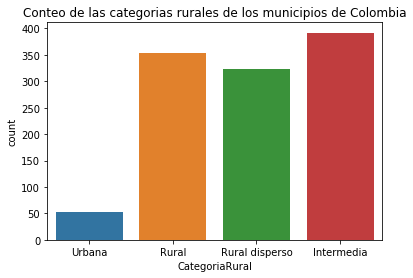

In [6]:
sns.countplot(data=result,x="CategoriaRural")
plt.title("Conteo de las categorias rurales de los municipios de Colombia")
plt.show()

# Guardar en csv
result.to_csv('data/ExtraccionRuralidad.csv', sep=';', encoding='utf-8', index=False)